In [1]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [2]:
# generate circles - rectangles pairs

number_of_images = 500
size = 256
imagesX = []
imagesY = []

for i in range(number_of_images):
    sample = np.zeros((size,size,3))
    for _ in range(5):
        x0 = random.randrange(5,size-5)
        y0 = random.randrange(5,size-5)
        r0 = random.randrange(25,50)
        sample = cv2.circle(sample,(x0,y0),r0,(150,50,255),-1)
        sample = cv2.circle(sample,(x0,y0),10,(50,250,255),-1)
    imagesX.append(sample)
    
for i in range(number_of_images):
    sample = np.zeros((size,size,3))
    for _ in range(5):
        x0 = random.randrange(5,size-5)
        y0 = random.randrange(5,size-5)
        r0 = random.randrange(25,50)
        sample = cv2.rectangle(sample,(x0,y0),(x0+r0,y0+r0),(50,255,100),-1)
        for v in range(x0,x0+r0,10):
            sample = cv2.line(sample,(v,y0),(v,y0+r0),(255,255,0),2)
    imagesY.append(sample)
    
imagesX = np.array(imagesX)
imagesX = imagesX / 255.0
imagesY = np.array(imagesY)
imagesY = imagesY / 255.0

In [4]:
# create networks
import pix2pix

channels = 3
generator_g = pix2pix.unet_generator(channels, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(channels, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [5]:
def sample_from_dataset(n,samples):
    prev_numbers = []
    samplesX = []
    new_labels = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
        new_labels.append(labels[number])
    new_samples = np.array(new_samples,dtype=float)    
    new_labels = np.array(new_labels)    
    return samplesX,samplesY

In [6]:
# Four optimizers for foue networks
g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# two loss functions
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def abs(image1,image2):
    return tf.reduce_mean(tf.abs(image1 - image2))

In [7]:
# one step - takes a 
#input: real_x, real_y
def step(real_x, real_y, e):
    with tf.GradientTape(persistent=True) as tape:
        # generate images
        fake_y = generator_g(real_x, training=True) 
        cycled_x = generator_f(fake_y, training=True) 
        fake_x = generator_f(real_y, training=True) 
        cycled_y = generator_g(fake_x, training=True) 
        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True) 
        # check results
        disc_real_x = discriminator_x(real_x, training=True) 
        disc_real_y = discriminator_y(real_y, training=True) 
        disc_fake_x = discriminator_x(fake_x, training=True) 
        disc_fake_y = discriminator_y(fake_y, training=True)
        #bce – binary cross entropy, abs – mean absolute error
        # discriminators losses
        disc_x_loss = bce(tf.ones_like(disc_real_x),disc_real_x) + bce(tf.zeros_like(disc_fake_x),disc_fake_x) 
        disc_y_loss = bce(tf.ones_like(disc_real_y),disc_real_y) + bce(tf.zeros_like(disc_fake_y), disc_fake_y) 
        # generators losses
        gen_g_loss = bce(tf.ones_like(disc_fake_y),disc_fake_y) 
        gen_f_loss = bce(tf.ones_like(disc_fake_x),disc_fake_x) 
        total_cycle_loss = abs(real_x, cycled_x) + abs(real_y, cycled_y) 
        identity_loss_x = abs(real_x, same_x)
        identity_loss_y = abs(real_y, same_y)
        # total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss_y
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss_x

    # Calculate the gradients for generators and discriminators 
    g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) 
    f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) 
    dx_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) 
    dy_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) 

    # Apply the gradients to the networks
    g_optimizer.apply_gradients(zip(g_grads, generator_g.trainable_variables)) 
    f_optimizer.apply_gradients(zip(f_grads, generator_f.trainable_variables)) 
    dx_opt.apply_gradients(zip(dx_grads, discriminator_x.trainable_variables)) 
    dy_opt.apply_gradients(zip(dy_grads, discriminator_y.trainable_variables))
    print('.',end='')
    if e%20==0:
        print("\nEpoch ",e)
        plt.figure(figsize=(15, 15))
        ax = plt.subplot(2, 2, 1)
        plt.imshow(real_x[0])
        ax = plt.subplot(2, 2, 2)
        plt.imshow(fake_y[0])
        ax = plt.subplot(2, 2, 3)
        plt.imshow(real_y[0])
        ax = plt.subplot(2, 2, 4)
        plt.imshow(fake_x[0])
        plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  0


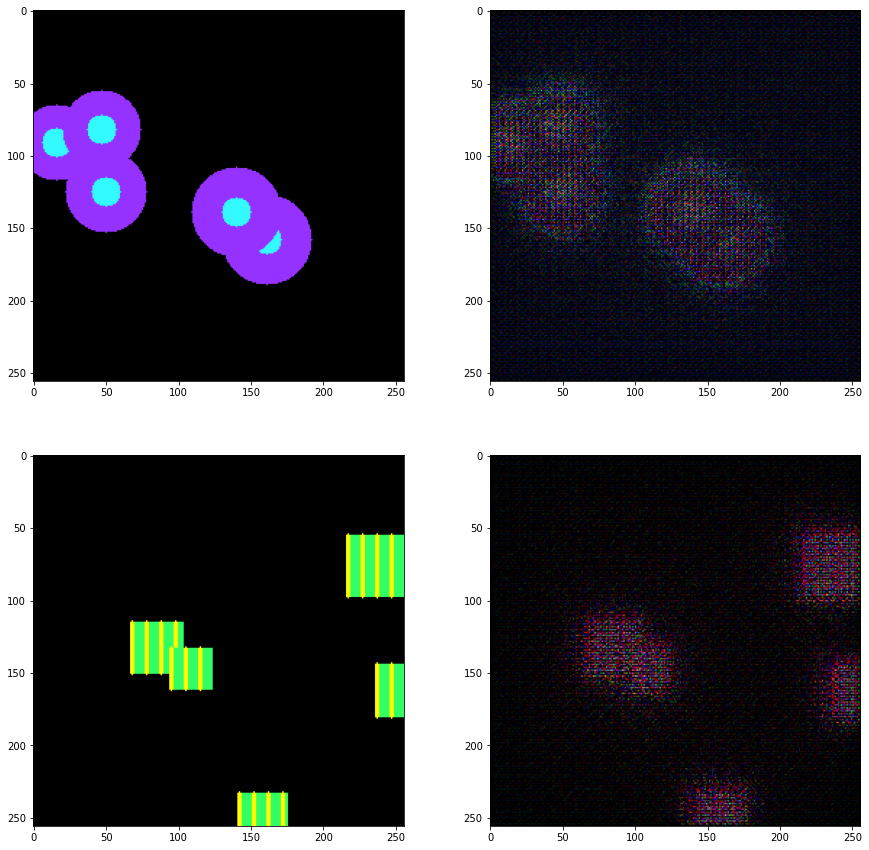

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  20


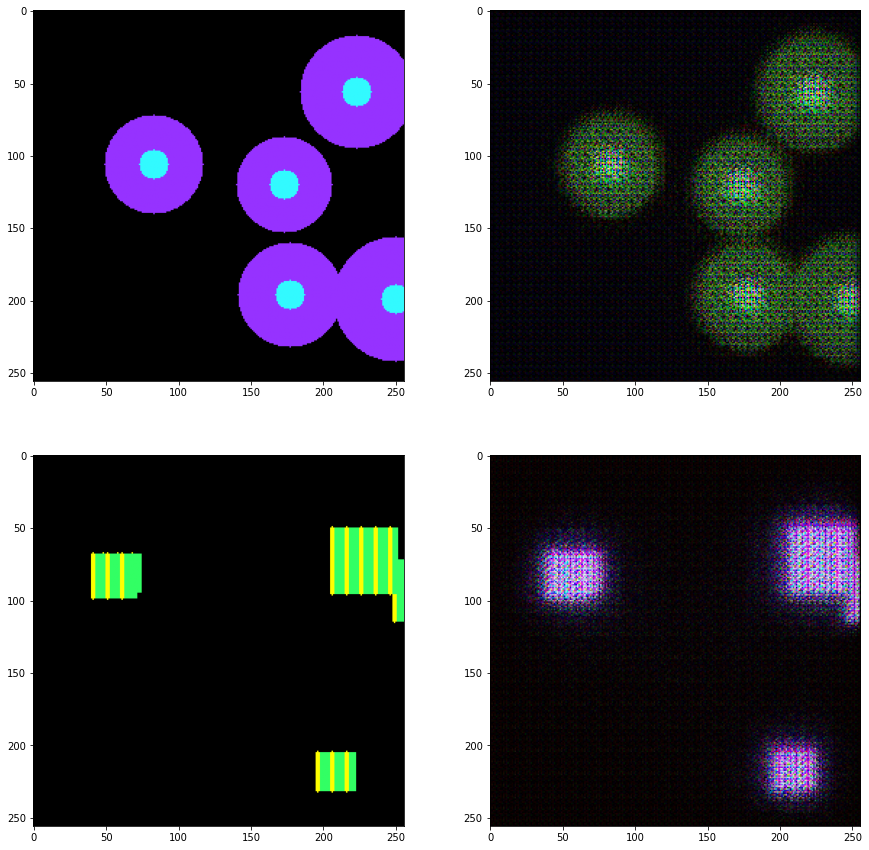

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  40


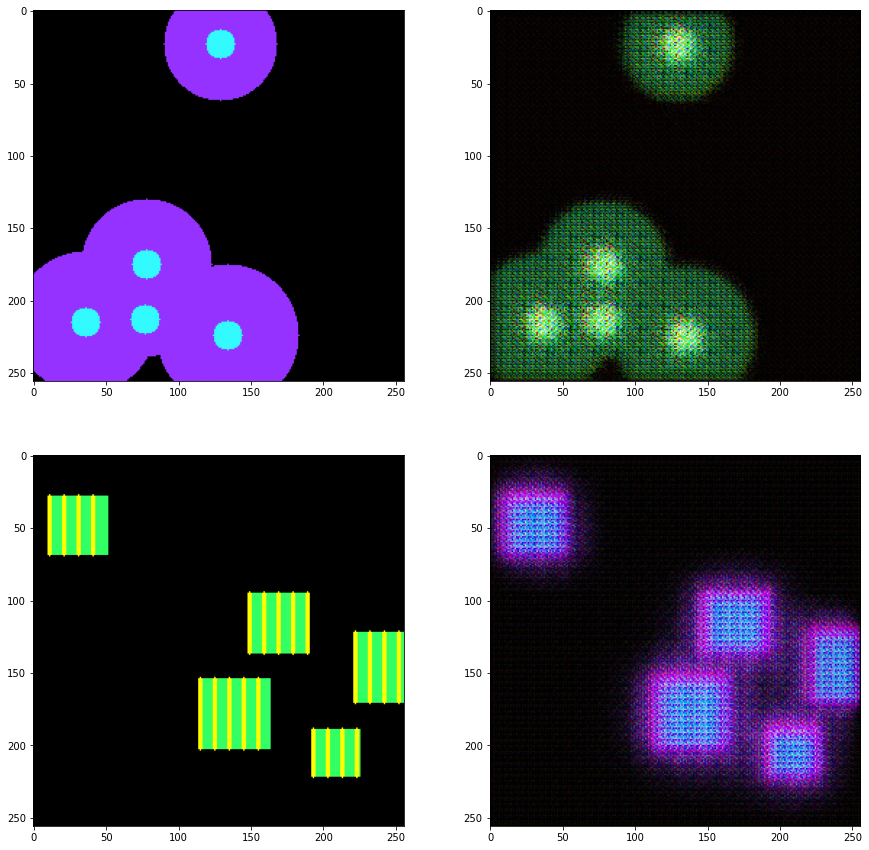

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  60


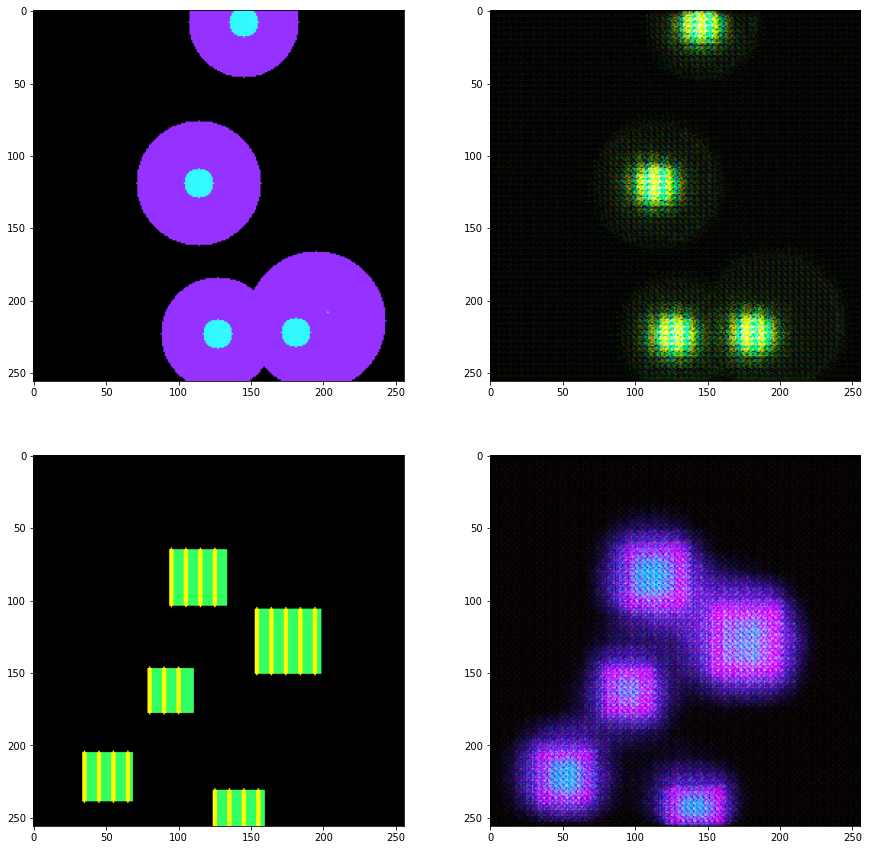

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  80


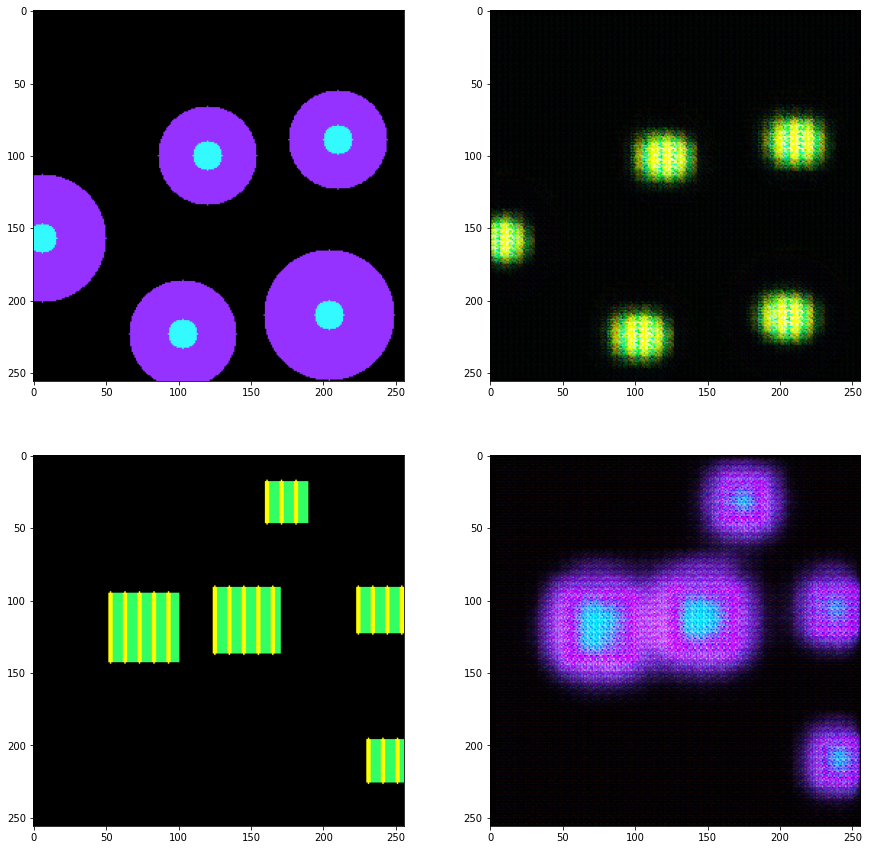

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  100


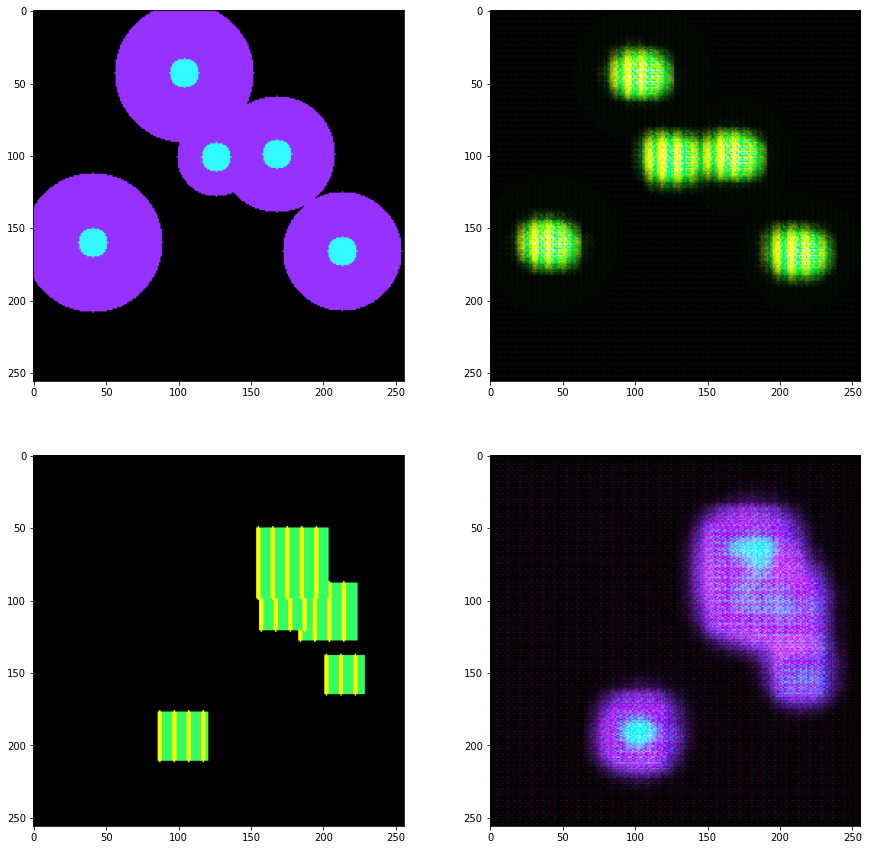

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  120


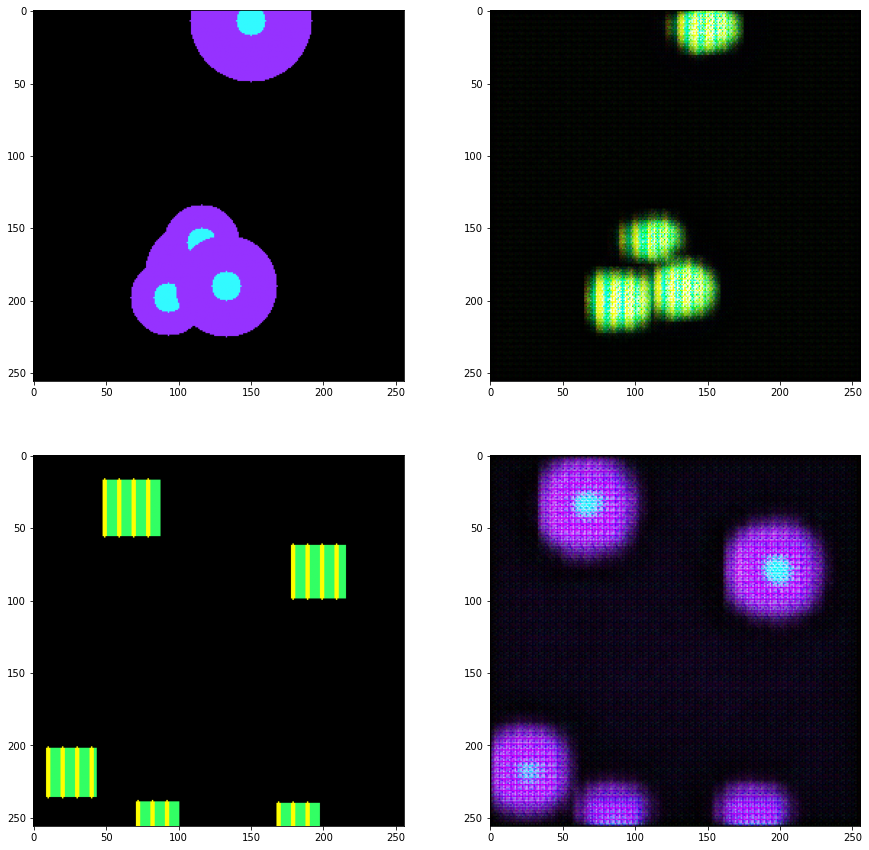

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  140


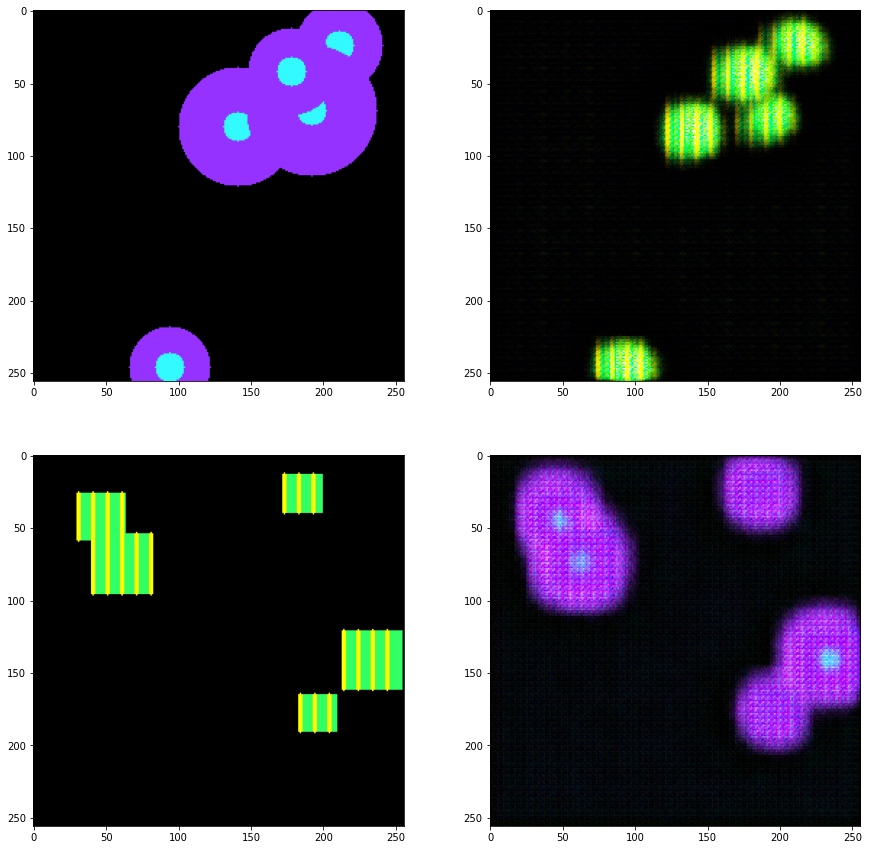

...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.
Epoch  160


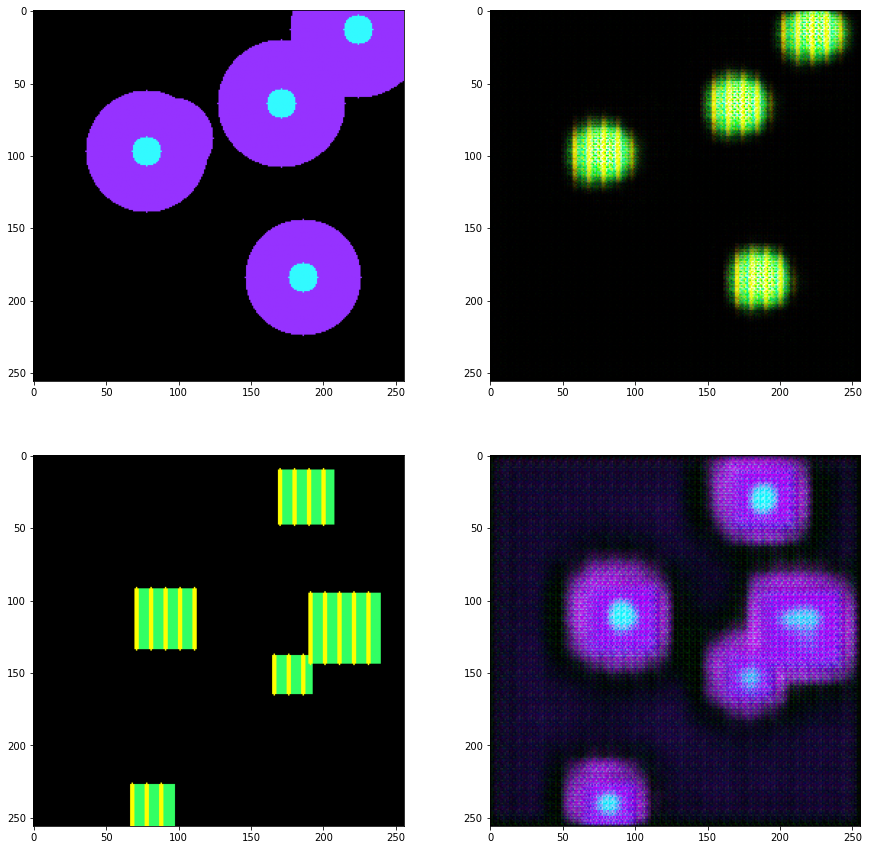

.

In [ ]:
EPOCHS = 1000
for e in range(EPOCHS):
    numberX = random.randrange(number_of_images)
    numberY = random.randrange(number_of_images)
    realX = imagesX[numberX]
    realY = imagesY[numberY]
    realX = np.expand_dims(realX,0)
    realY = np.expand_dims(realY,0)
    step(realX,realY,e)
    